In [1]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import statsmodels.api as sm

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

# Helper Functions

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

In [3]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

# Data Preparation

In [4]:
indicators = ['NAEXKP01USQ652S', # GDP
              'USAGFCFQDSMEI', # Investment
              'USAPFCEQDSMEI', # HH consumption
              'TOTLQ', # non-farm hours worked
              'FEDFUNDS', # real interest rate
              'CES0500000003' # average hourly wage
             ]

nice_names = ['Y', 'I', 'C', 'N', 'r_G', 'w']

from pandas_datareader.fred import FredReader

# os is a package to do stuff with your operating system (look for files, make/delete directories, etc)
import os 


# check if the data is already downloaded
if not os.path.isfile('../data/us_fred_data.csv'):
    # If it's not, download it and save it
    data = FredReader(symbols=indicators, start='1900', end=None).read()
    data.to_csv('../data/us_fred_data.csv')
else:
    # Otherwise, load it from disk
    data = pd.read_csv('../data/us_fred_data.csv', index_col=0, parse_dates=['DATE'])
    
data = data.rename(columns=dict(zip(indicators, nice_names)))

## Decide what to do

Steps:

1. Check info().
    1. Make sure you have a DatetimeIndex
    2. Make sure all columns are numeric (Dtype is float64)
2. Check head()
    1. Head shows the first 5 rows of data. Just make sure it looks as expected. 
3. Plot the data.
    1. Plots are always the best diagnostic tool. Plot each data separately and make sure they match what you saw on the website. Make sure it makes economic sense.

### Check `info`

In this case, we're good. We have a DatetimeIndex, and all Dtype are `float64`. I see that `FEDFUNDS` has 833 non-null (not missing) values, while the others have only 255. I guess FEDFUNDS is a higher frequency than the others, so that will need to be addressed.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 833 entries, 1954-07-01 to 2023-11-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       255 non-null    float64
 1   I       255 non-null    float64
 2   C       255 non-null    float64
 3   N       235 non-null    float64
 4   r_G     833 non-null    float64
 5   w       213 non-null    float64
dtypes: float64(6)
memory usage: 45.6 KB


In [6]:
data.index.inferred_freq

'MS'

`w` is a strange one, it doesn't have the same number of values as the others. It makes me want to look at it alone, dropping the missing values.

When we do, we see that it is also monthly. We will need to aggregate it to quarterly.

In [7]:
data.w.dropna().head()

DATE
2006-03-01    20.04
2006-04-01    20.15
2006-05-01    20.13
2006-06-01    20.23
2006-07-01    20.29
Name: w, dtype: float64

### Check head

It looks like FEDFUNDS is monthly, and goes back a lot longer than the other series.

In [8]:
data.head()

,Y,I,C,N,r_G,w
DATE,,,,,,
1954-07-01,NaN,NaN,NaN,NaN,0.80,NaN
1954-08-01,NaN,NaN,NaN,NaN,1.22,NaN
1954-09-01,NaN,NaN,NaN,NaN,1.07,NaN
1954-10-01,NaN,NaN,NaN,NaN,0.85,NaN
1954-11-01,NaN,NaN,NaN,NaN,0.83,NaN


### Plot the data

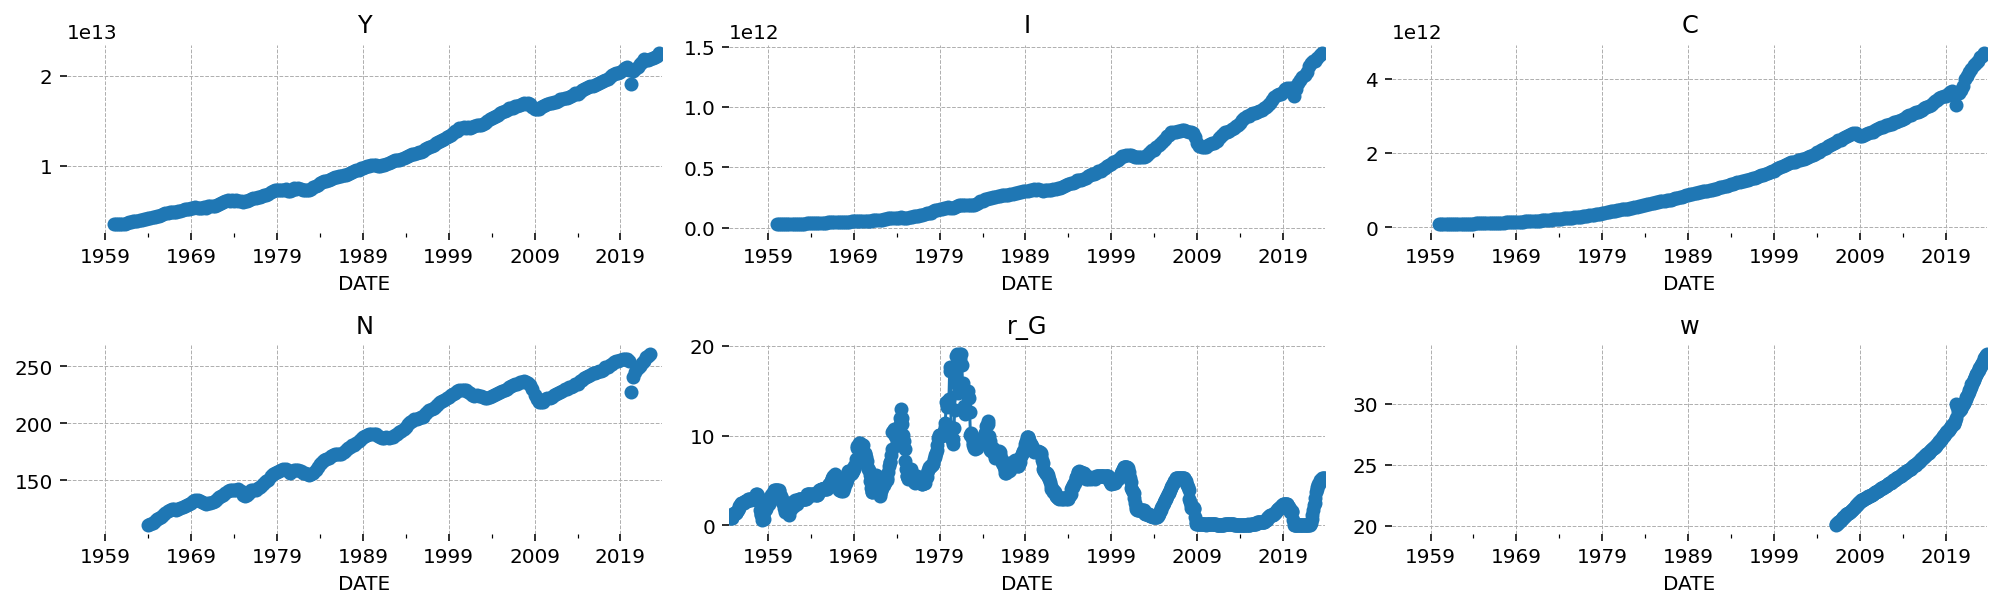

In [9]:
def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()
    
plot_df(data, marker='o')

What do we get from these plots?

1. Everyone is non-stationary, except for r_G.
2. We have lots of missing data for w. For others, we're only missing a bit (r_G goes back to looks like about 1950, others go back until 1960).

## Plan of action:

1. We need to re-sample the data to convert r_G to quarterly. We need to do this first because otherwise the next step will be screwed up. It is a **RATE** variable, so we have to do some special stuff:
    1. Looking at the plot, it's currently in percentages (it goes from 0 to 20). We would like it in decimals, so we need to divide by 100.
    2. We need to **compound** the interest as we aggregate. The rate we get for holding 1 month is not the same as what we get for holding 3 months! The formula to use is $\prod_i (1 + r_i) - 1$. In code, that's `(1 + rate).prod() - 1`

2. **Before we do anything**, we need to make a train/test split. This will allow us to validate our model on out-of-sample data. I will cut out the last 10 observations and save them to check how well the model forecasts.


3. After re-sampling, we need to make the data stationary. We will use OLS to do this.
    1. **ATTENTION**: Before detrending (via HP filter or OLS), you need to:
        1. Make prices constant
        2. Take logs
        3. Remove the seasonality (if using HP filter)
    2. **ATTENTION 2**: Never log/detrend rate variables like `r_G`!!! For these, you just need to remove the sample mean.

### Resample `r_G`.

Let's break the `r_G` column off into it's own variable

In [10]:
r_G = data['r_G'].copy()
r_G.head()

DATE
1954-07-01    0.80
1954-08-01    1.22
1954-09-01    1.07
1954-10-01    0.85
1954-11-01    0.83
Name: r_G, dtype: float64

Use `resample` together with our aggregation function. To pass an arbitrary aggregation function, use the `.agg()` method. We will need to write a function to do the interest compounding.

In [11]:
def compound_interest(monthly_interests):
    quarterly_interest = (1 + monthly_interests).prod() - 1
    return quarterly_interest

# Multiply by 0.01 (divide by 100) to covert percents to decimals
r_G_decimal = r_G.mul(1 / 100)

# Resample the data to quarterly
r_G_quarterly = r_G_decimal.resample('QS').agg(compound_interest)

# Check your model to know whether you need to add 1 to the data
r_G_quarterly = r_G_quarterly + 1
r_G_quarterly.head()

DATE
1954-07-01    1.031215
1954-10-01    1.029886
1955-01-01    1.040844
1955-04-01    1.045677
1955-07-01    1.059330
Freq: QS-JAN, Name: r_G, dtype: float64

Use `.join()` to bring `r_G_quarterly` back into the data. We will need to drop the old `r_G` as well.

In [12]:
data = data.drop(columns=['r_G']).join(r_G_quarterly)
data.head()

,Y,I,C,N,w,r_G
DATE,,,,,,
1954-07-01,NaN,NaN,NaN,NaN,NaN,1.031215
1954-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1954-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1954-10-01,NaN,NaN,NaN,NaN,NaN,1.029886
1954-11-01,NaN,NaN,NaN,NaN,NaN,NaN


### Resample `w`

We need to do the same steps on `w`. Unlike `r_G`, `w` is a flow variable (why? Because I get a different wage if I work 1 hour than if I work 8 hours). Thus, we use the `sum` function to aggregate.

In [13]:
# First, split it into it's own variable
w_monthly = data['w'].copy()

# Resample and take the sum
w_quarterly = w_monthly.dropna().resample('QS').sum()

# Add it back into the data, dropping the old data
data = data.drop(columns=['w']).join(w_quarterly)

### Current to Constant

If you have current prices, you will have to make a **PRICE INDEX**.

1. Download CPI data
2. Choose a base year
3. Compute the index as CPI / CPI_BASE_YEAR
4. Multiply your current price data by the price index you made in step (3).

### Currency Conversion

1. Download exchange rate data
2. Multiply.
3. Done.

## Re-check the data

Now `r_G` and `w` have the same number of non-missing values, which makes me somewhat confident I didn't make a mistake.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 833 entries, 1954-07-01 to 2023-11-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       255 non-null    float64
 1   I       255 non-null    float64
 2   C       255 non-null    float64
 3   N       235 non-null    float64
 4   r_G     278 non-null    float64
 5   w       72 non-null     float64
dtypes: float64(6)
memory usage: 45.6 KB


I'm going to drop all the rows where every value is missing. It's OK if there are missing values in the data, though! We're not going to do OLS -- our method of fitting the data can handle missing data. To specify that we only want to drop the rows where **everything** is missing, use `how='all'`

At this point I'm going to rename from `data` to `df`. This is because I now have the final dataframe object I'm going to work with.

In [15]:
df = data.dropna(how='all')
df.head()

,Y,I,C,N,r_G,w
DATE,,,,,,
1954-07-01,NaN,NaN,NaN,NaN,1.031215,NaN
1954-10-01,NaN,NaN,NaN,NaN,1.029886,NaN
1955-01-01,NaN,NaN,NaN,NaN,1.040844,NaN
1955-04-01,NaN,NaN,NaN,NaN,1.045677,NaN
1955-07-01,NaN,NaN,NaN,NaN,1.059330,NaN


Notice how there are endpoint effects on `w`! This is because we have incomplete quarterly data. To fix it, I will just drop the endpoints.

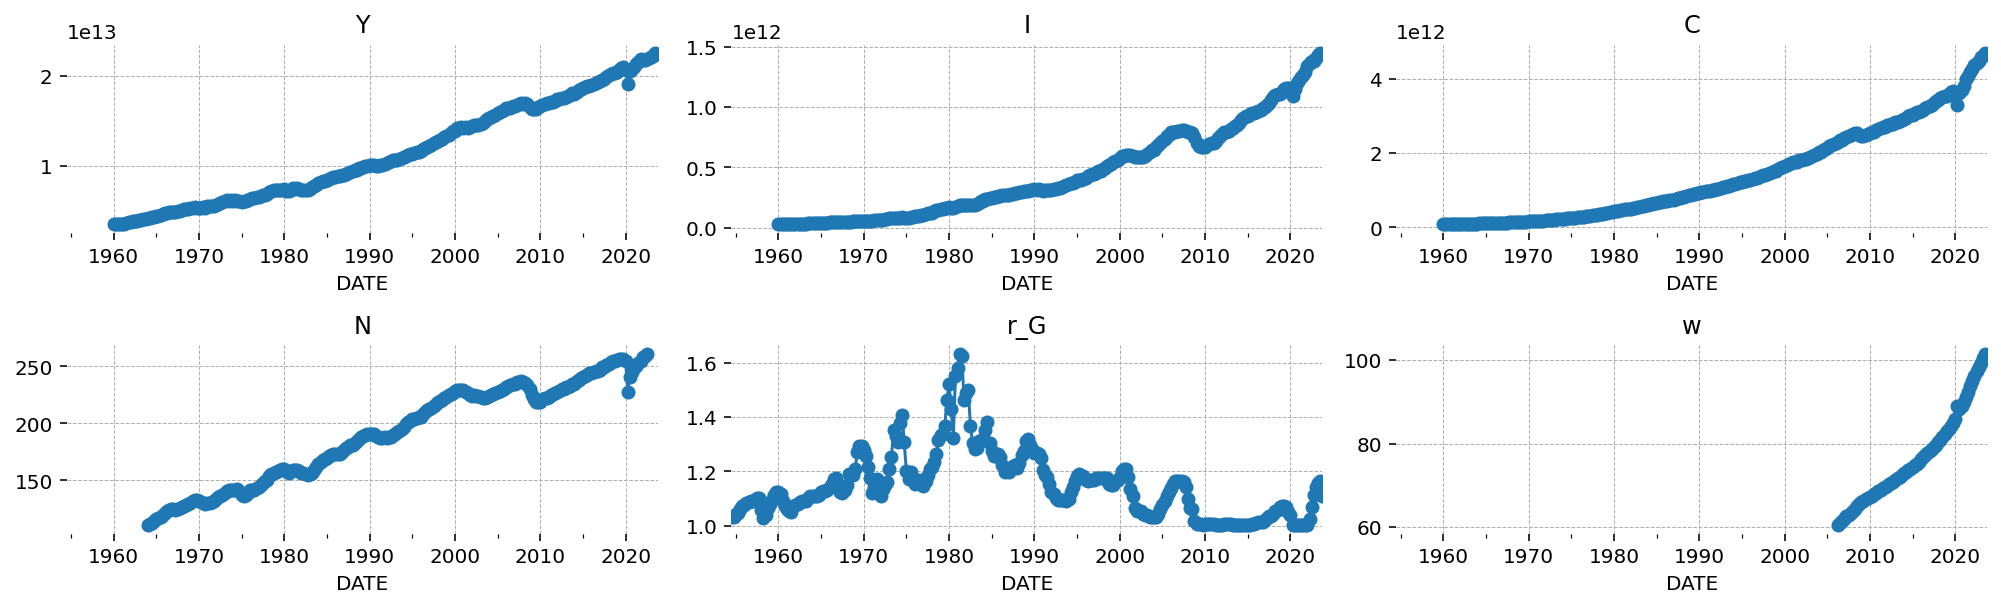

In [23]:
plot_df(df, marker='o')

In [24]:
# Drop the incomplete endpoints by setting them to missing
df.loc[['2006-01-01', '2023-10-01'], 'w'] = np.nan

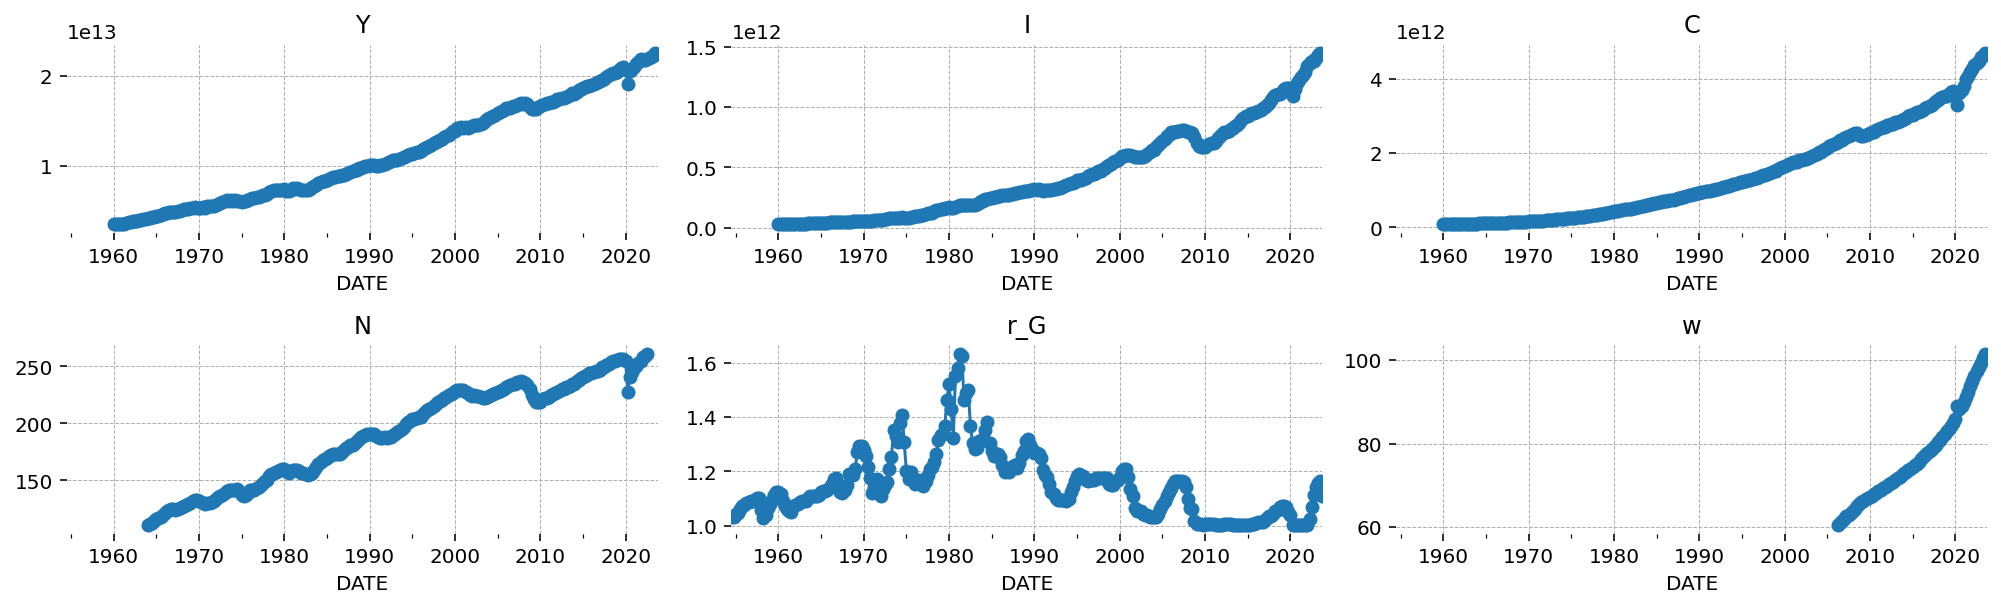

In [25]:
plot_df(df, marker='o')

### Train/Test Split

In [68]:
# Choose the number of training samples to take. I will take 10.
n_test = 10

# Use iloc (for "index location") to select rows by their numerical position (rather than their date). 
df_train = df.iloc[:-n_test, :].copy()
df_test = df.iloc[-n_test:, :].copy()

**ATTENTION**! From now on, we look only at the training set! Looking at the test data is cheating. If you try to change your model to do a better job on the test data, it's called [*data leakage*](https://en.wikipedia.org/wiki/Data_leakage), and it will result in your model doing a worse job at forecasting. 

Remember, the job of a model is to fit the **population**, not the sample! The point of a train/test split is to check how well we are fitting the (unobserved) population, rather than just the sample.

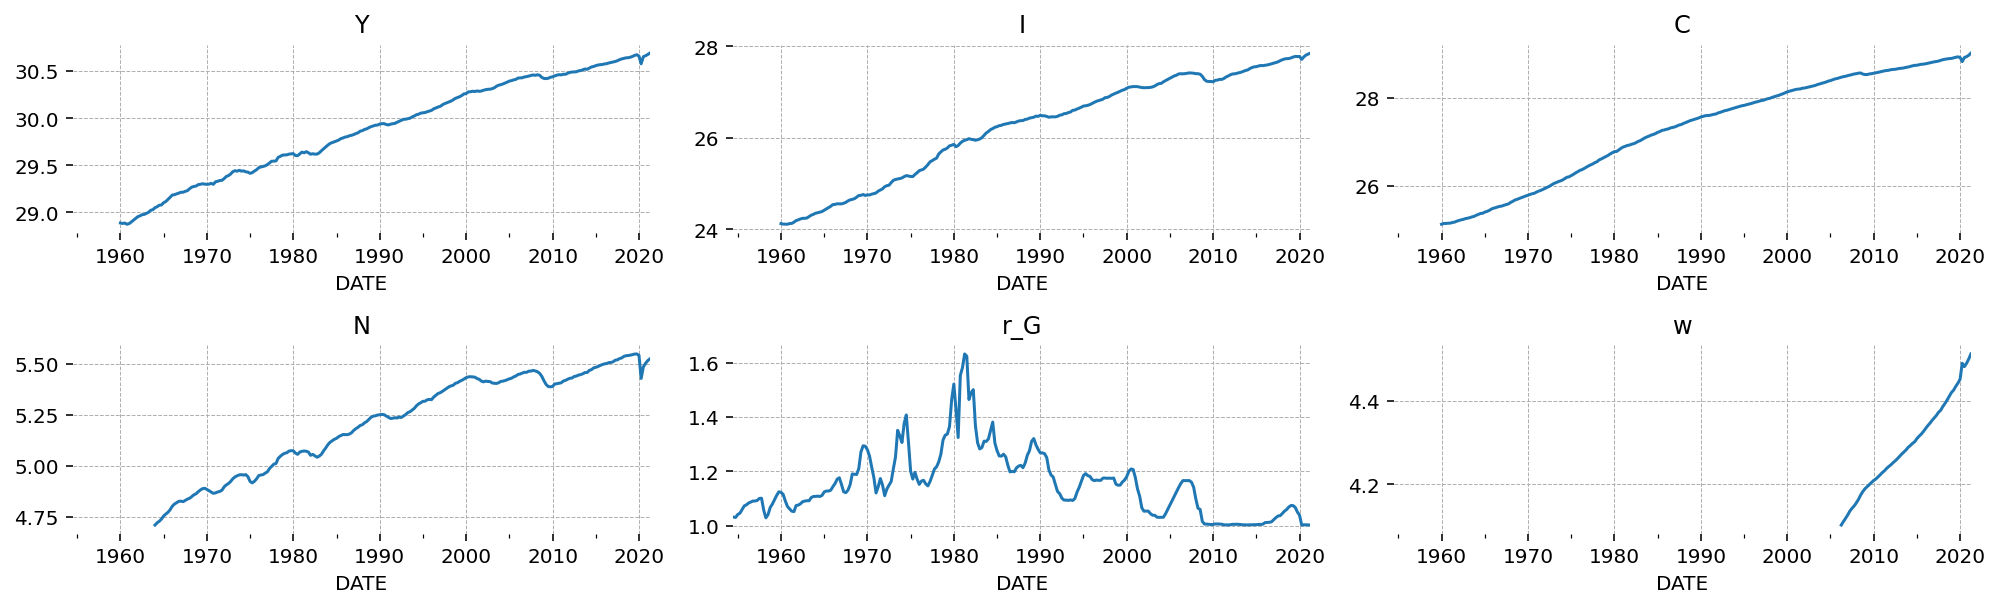

In [69]:
# How to detrend:
# 1. Take logs (if necessary)
# 2. Run OLS regression, save residuals
# 3. Done.

log_df_train = df_train.copy()
log_df_test = df_test.copy()
log_df_train[['Y', 'I', 'C', 'N', 'w']] = np.log(log_df_train[['Y', 'I', 'C', 'N', 'w']])
log_df_test[['Y', 'I', 'C', 'N', 'w']] = np.log(log_df_test[['Y', 'I', 'C', 'N', 'w']])

plot_df(log_df_train)

In [75]:
ADF_test_summary(log_df_train, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.018         -1.524        0.821          0    -3.996      -3.429     -3.138
	Constant             0.539          1.553        0.122
	Trend                0.000          1.264        0.207
Constant Only               -0.003         -2.441        0.131          0    -3.457      -2.873     -2.573
	Constant             0.103          2.628        0.009
No Constant                  0.000         10.553        1.000          0    -2.575      -1.942     -1.616
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

In [96]:
N = df.shape[0]
constant = np.ones(N)
time = np.linspace(0, 1, N)
X = pd.DataFrame(np.c_[constant, time, time ** 2, time ** 3, pd.get_dummies(df.index.quarter, drop_first=True).values * 1.], 
                 index=df.index, 
                 columns=['constant', 'time', 'time^2', 'time^3', 'Q2', 'Q3', 'Q4'])

X_train = X.iloc[:-n_test, :] 
X_test = X.iloc[-n_test:, :] 

In [97]:
for variable in ['Y', 'I', 'C', 'N', 'w']:
    mod = sm.OLS(log_df_train[variable], X_train, hasconst=True, missing='drop')
    res = mod.fit()
    detrended_data = res.resid
    log_df_train[variable] = detrended_data
    
    test_pred = res.predict(X_test)
    test_resid = log_df_test[variable] - test_pred
    
    log_df_test[variable] = test_resid
    
    break
    
# r_G_mu_train = log_df_test['r_G'].mean()
# log_df_train['r_G'] = log_df_train['r_G'] - r_G_mu_train
# log_df_test['r_G'] = log_df_test['r_G'] - r_G_mu_train


In [99]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                -4.506e-15
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               1.00
Time:                        11:00:09   Log-Likelihood:                 500.90
No. Observations:                 246   AIC:                            -987.8
Df Residuals:                     239   BIC:                            -963.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant   -1.625e-16      0.015  -1.05e-14      1.000      -0.030       0.030
time         1.24e-15      0.114   1.09e-14      1.000      -0.225       0.225
time^2     -2.733e-15      0.244  -1.12e-14      1.000      -0.481       0.481
time^3      1.748e-15      0.154   1.13e-14      1.000      -0.304       0.304
Q2         -4.467e-21      0.006  -7.76e-19      1.000      -0.011       0.011
Q3         -2.582e-18      0.006  -4.47e-16      1.000      -0.011       0.011
Q4          1.599e-18      0.006   2.77e-16      1.000      -0.011       0.011
==============================================================================
Omnibus:                        3.700   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                2.620
Skew:                          -0.078   Prob(JB):                        0.270
Kurtosis:                       2.519   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

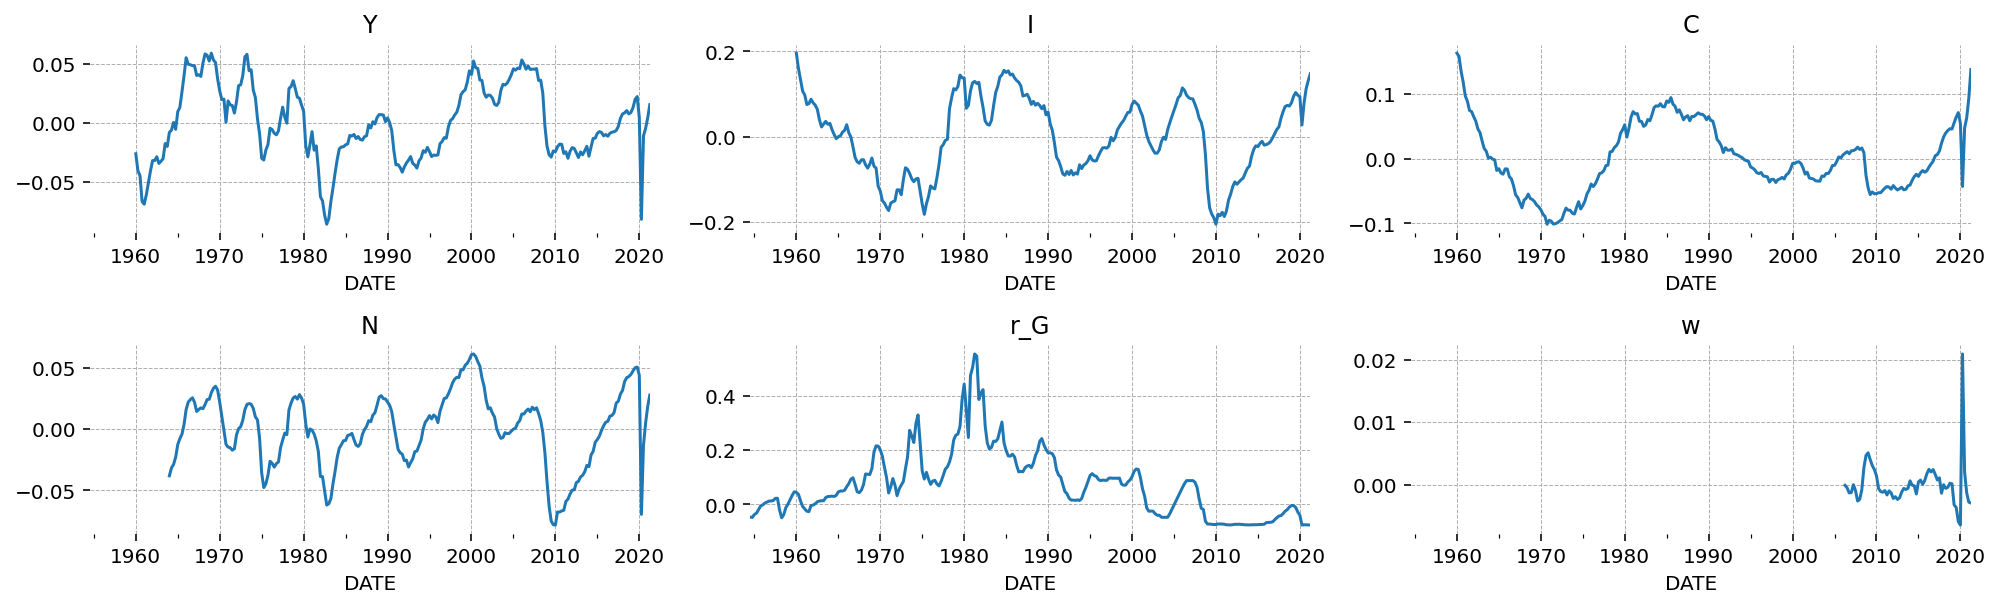

In [82]:
plot_df(log_df_train)

In [83]:
ADF_test_summary(log_df_train, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.058         -2.717        0.229          0    -3.996      -3.429     -3.138
	Constant             0.000          0.228        0.820
	Trend               -0.000         -0.122        0.903
Constant Only               -0.058         -2.722        0.070          0    -3.457      -2.873     -2.573
	Constant             0.000          0.245        0.806
No Constant                 -0.058         -2.728        0.006          0    -2.575      -1.942     -1.616
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

In [7]:
rbc = ge.gEconModel('../gcn_files/RBC_w_bonds.gcn')

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [8]:
for equation in rbc.system_equations:
    display(equation)

-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

beta*lambda_t+1 - lambda_t/r_G_t

-Div_t + TC_t + Y_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)